In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
from ler.lens_galaxy_population import optical_depth
from numba import njit
from tqdm import tqdm
from ler.lens_galaxy_population import optical_depth_sie2_mp, optical_depth_sie1_mp 
from ler.utils import cubic_spline_interpolator, inverse_transform_sampler
from ler.lens_galaxy_population import phi_cut_SIE, axis_ratio_rayleigh
from multiprocessing import Pool


In [2]:
od4 = optical_depth.OpticalDepth(
    npool=2,
    z_min=0.001,
    z_max=10.0,
    functions=dict(
        strong_lensing_condition="rjs_with_cross_section",
        optical_depth="optical_depth_SIE_hemanta",
    ),
    sampler_priors=dict(
        lens_redshift="lens_redshift_SDSS_catalogue",
        velocity_dispersion="velocity_dispersion_ewoud",
        axis_ratio="axis_ratio_rayleigh",
    ),
    sampler_priors_params=dict(
        lens_redshift=dict(z_min=0.001, z_max=10),
        velocity_dispersion=dict(vd_min=0, vd_max=600),
        axis_ratio=dict(q_min=0.2, q_max=1),
    ),
    cosmology=cosmo,
    directory="./interpolator_pickle",
    create_new_interpolator=dict(
        velocity_dispersion=dict(create_new=True, resolution=100), 
        optical_depth=dict(create_new=True, resolution=100),
        z_to_Dc=dict(create_new=False, resolution=100), 
        Dc_to_z=dict(create_new=False, resolution=100),
        angular_diameter_distance=dict(create_new=False, resolution=100),
        differential_comoving_volume=dict(create_new=False, resolution=100),
        )
    )

z_to_Dc interpolator will be loaded from ./interpolator_pickle/z_to_Dc/z_to_Dc_1.pickle
Dc_to_z interpolator will be loaded from ./interpolator_pickle/Dc_to_z/Dc_to_z_1.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_1.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_0.pickle
velocity_dispersion_ewoud interpolator will be generated at ./interpolator_pickle/velocity_dispersion_ewoud/velocity_dispersion_ewoud_3.pickle
optical_depth_SIE_hemanta interpolator will be generated at ./interpolator_pickle/optical_depth_SIE_hemanta/optical_depth_SIE_hemanta_4.pickle


In [15]:
# set up the parameters
zs = np.linspace(0.001, 5, 100)
zs = np.array([zs]).reshape(-1)
no = 8*1e-3*od4.cosmo.h**3
vd_inv_cdf = od4.vd_inv_cdf
splinedVcdz = od4.splinedVcdz
splineDa = od4.splineDa
idx = np.arange(len(zs))
zl_list = np.linspace(0.001, 5, 100)

input_params = [(zs[i], no, vd_inv_cdf, splinedVcdz, splineDa, idx[i], zl_list) for i in range(len(zs))]

In [17]:
# Create a pool of workers and parallelize the integration
tau_list = np.zeros(len(zs))
with Pool(processes=od4.npool) as pool:
    for result in tqdm(
        pool.imap(optical_depth_sie2_mp, input_params),
        total=len(input_params),
        ncols=100,
        disable=False,
    ):

        j, tau_j = result
        tau_list[j] = tau_j

  0%|                                                                       | 0/100 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


In [20]:
# Create a pool of workers and parallelize the integration
with Pool(processes=4) as pool:
    result = list(pool.map(optical_depth_sie2_mp, input_params))

result = np.array(result)
tau_list = result[:,1][np.array(result[:,0], dtype=int)]

In [21]:
tau_list

array([8.83914634e-13, 1.16905355e-07, 8.74612915e-07, 2.80263710e-06,
       6.35766048e-06, 1.19036784e-05, 1.96647893e-05, 2.99412362e-05,
       4.27758956e-05, 5.84527634e-05, 7.66414965e-05, 9.76672852e-05,
       1.20885539e-04, 1.47619259e-04, 1.76468897e-04, 2.06672617e-04,
       2.40550375e-04, 2.76045681e-04, 3.14570109e-04, 3.53273348e-04,
       3.94575169e-04, 4.37402334e-04, 4.80101181e-04, 5.25850381e-04,
       5.72692592e-04, 6.19926104e-04, 6.68136022e-04, 7.16769454e-04,
       7.66839597e-04, 8.16850037e-04, 8.67295814e-04, 9.18159810e-04,
       9.69757696e-04, 1.02231574e-03, 1.07117318e-03, 1.12480841e-03,
       1.17479436e-03, 1.22489394e-03, 1.27768638e-03, 1.32725216e-03,
       1.37748739e-03, 1.42527478e-03, 1.48018477e-03, 1.53227322e-03,
       1.57341320e-03, 1.62318287e-03, 1.66868650e-03, 1.71803757e-03,
       1.76810762e-03, 1.81412651e-03, 1.85865280e-03, 1.90472580e-03,
       1.94926831e-03, 1.99656704e-03, 2.04457762e-03, 2.07869357e-03,
      

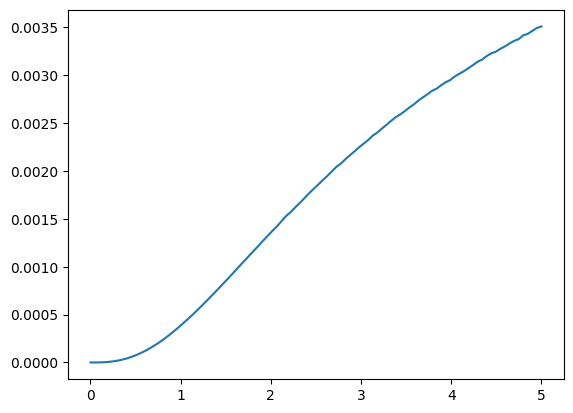

In [22]:
plt.plot(zs, tau_list)

In [7]:
params = input_params[2]

# integrand
zs = params[0]
no = params[1]
z_list = params[6]
vd_inv_cdf = params[2]
vd_inv_cdf_coeff = vd_inv_cdf[:,0]
vd_list = vd_inv_cdf[0,1]
vd_sampler = njit(lambda size_,zl_: inverse_transform_sampler(size_, vd_inv_cdf_coeff[np.searchsorted(z_list, zl_)], vd_list))

splineDa = params[4]
splineDa_coeff = splineDa[0]
splineDa_z_list = splineDa[1]
Da_zs = cubic_spline_interpolator(np.array([zs]), splineDa_coeff, splineDa_z_list)[0]
Da = njit(lambda zl_: cubic_spline_interpolator(np.array([zl_]), splineDa_coeff, splineDa_z_list)[0])

splinedVcdz = params[3]
dVcdz = njit(lambda zl_: cubic_spline_interpolator(np.array([zl_]), splinedVcdz[0], splinedVcdz[1])[0])

In [8]:
def tau_integrand(zl, zs):
    # velocity dispersion #
    zl=0.5
    size = 5
    sigma = vd_sampler(size, zl)
    q = axis_ratio_rayleigh(sigma)
    # einstein radius 
    Dls = (Da_zs*(1+zs) - Da(zl)*(1+zl))/(1+zs)
    theta_E = (
            4.0 * np.pi * (sigma / 299792.458) ** 2 * Dls / Da_zs
        )  
    cross_section_SIS = theta_E ** 2  # np.pi is ommited
    result = phi_cut_SIE(q) * cross_section_SIS/4 * no * dVcdz(zl)
    return np.mean(result)

In [9]:
tau_integrand(0.5, 1)

0.0007150603560364423

In [31]:
test = axis_ratio_rayleigh(sigma=np.random.uniform(0., 600, 50000))

In [29]:
len(test) 

50000